# Estimating intersection with HyperLogLog
In this notebook we will explore three different methods to estimate the intersection of two sets using [HyperLogLog counters](https://github.com/LucaCappelletti94/hyperloglog-rs). The first method is usually referred to as [inclusion-exclusion principle](https://en.wikipedia.org/wiki/Inclusion%E2%80%93exclusion_principle), the second method computes a new HyperLogLog counter from the minimum of the two counters (somewhat inspired by how [MinHash](https://github.com/LucaCappelletti94/minhash-rs) operates) and the third method uses the [Maximum Likelihood Estimation (MLE) to have a better estimate of the intersection cardinality](https://oertl.github.io/hyperloglog-sketch-estimation-paper/paper/paper.pdf). But let's start from the very basics!

## What is the cardinality of a set?
The cardinality of a set is the number of elements in the set. For example, the cardinality of the set `{1, 2, 3}` is `3`. The cardinality of a set can be computed by iterating over the elements of the set and counting them. If the set is very large, it is not possible to store it in memory and therefore we need to use a different approach.

### Sets where HyperLogLog is needed to estimate the cardinality
Suppose you are a company that crawls the internet, such as Google. You want to know the unique number of pages you have visited, but it is not possible to store into an hash-based set all of these pages, because there are too many of them. In this case, you can use a probabilistic data structure such as a HyperLogLog counter to estimate the cardinality of the set of pages you have visited.

## What is the intersection of two sets?
The intersection of two sets is the set of elements that are present in both sets. For example, the intersection of the sets `{1, 2, 3}` and `{2, 3, 4}` is `{2, 3}`. If the sets are very large, it is not possible to store them in memory and therefore we need to use a different approach, that stores the structure of the two sets implicitly, without storing the elements of the sets themselves.

### Sets where HyperLogLog is needed to estimate the intersection
Suppose your company has been running multiple crawlers, and you want to know whether two crawlers are now colliding with each other and exploring the same pages. As before, we cannot store the sets of pages visited by the two crawlers in memory, and therefore we need to use a probabilistic data structure such as a HyperLogLog counter to estimate the intersection of the two sets.

## But what exactly is an HyperLogLog counter?
An HyperLogLog counter is a probabilistic data structure used to estimate the cardinality of a set. It is based on the observation that the cardinality of a set can be estimated by the maximum number of leading zeros in the binary representation of the hashes of the elements of the set. The HyperLogLog counter is a data structure that stores the maximum number of leading zeros for a set of hashes. The counter is initialized with a number of bits, which determines the maximum number of leading zeros that can be stored. The counter is then updated with the hashes of the elements of the set. The estimate of the cardinality is then given by the harmonic mean of the values stored in the counter. HyperLogLog counters can be used to compute the cardinality of the union of two sets by taking the maximum of the values stored in the two counters, and therefore we can also compute the intersection of two sets. The methods we can employ to estimate the intersection of two sets using HyperLogLog counters are the subject of this notebook.

[Learn more about HyperLogLog in the original paper here](https://static.googleusercontent.com/media/research.google.com/it//pubs/archive/40671.pdf).

Here follows an illustration of how an element to be counted is inserted in the HyperLogLog:

![HyperLogLog insertion of an element](https://github.com/LucaCappelletti94/hyperloglog-rs/blob/main/registers_hll.png?raw=true)

### Inclusion-exclusion principle
The first method we will explore is the [inclusion-exclusion principle](https://en.wikipedia.org/wiki/Inclusion%E2%80%93exclusion_principle). The inclusion-exclusion principle states that the cardinality of the union of two sets is given by the sum of the cardinality of the two sets minus the cardinality of the intersection of the two sets. Therefore, we can estimate the cardinality of the intersection of two sets by computing the cardinality of the union of the two sets and subtracting the cardinality of the two sets. The cardinality of the union of two sets can be computed using the HyperLogLog counter as described above, and therefore we can estimate the cardinality of the intersection of two sets using the inclusion-exclusion principle.

![Inclusion-exclusion principle](https://github.com/LucaCappelletti94/hyperloglog-rs/blob/main/intersection.jpg?raw=true)

### Minimum of two counters
An approach we include for completeness sake, as I have encountered it being used in the wild, is to estimate the HyperLogLog counter representing the intersection of the two sets by computing the minimum register-wise. The cardinality of this new HyperLogLog counter is then meant to estimate the cardinality of the intersection of the two sets. This approach is inspired by how [MinHash](https://github.com/LucaCappelletti94/minhash-rs) operates. We will provide in the benchmarks that, while this approach in the MinHash datastructure can provide a good estimate of the intersection cardinality, it is not viable for HyperLogLog counters.

![Min intersection](https://github.com/LucaCappelletti94/hyperloglog-rs/blob/main/min_intersection.png?raw=true)

#### How MinHash operates
While we exclude MinHash from the current benchmark lineup, as we have already [extensively benchmarked MinHash in the past](https://github.com/LucaCappelletti94/minhash-rs/blob/main/MinHash%20Jaccard%20benchmarks.ipynb), I still wanted to provide a gist of how the data structure operates. MinHash is a probabilistic data structure that estimates the Jaccard similarity between two sets. The Jaccard similarity between two sets is the cardinality of the intersection of the two sets divided by the cardinality of the union of the two sets. The MinHash data structure is initialized with a number of hash functions, which determines the number of words that will be used to store the hashes of the elements of the set. All words are initialized with the maximum value that you can store in that word ([which in fancy talk is referred to as a Mersenne prime number](https://en.wikipedia.org/wiki/Mersenne_prime)). When you intend to insert a new element, you compute all of the hashes for the element and update the words where the hash of the element is the minimum. The estimate of the Jaccard similarity is then given by the number of equal values in the same position of the two words divided by the number of hash functions.

![MinHash diagram](https://github.com/LucaCappelletti94/minhash-rs/raw/main/minhash_diagram.jpg?raw=true)

### Maximum Likelihood Estimation
Finally, we will explore the Maximum Likelihood Estimation (MLE) approach. You can [read the details of this approach in the original paper by Otmar Ertl here](https://oertl.github.io/hyperloglog-sketch-estimation-paper/paper/paper.pdf). THE MLE approach to jointly estimate the intersection of two HyperLogLog counters is based on the principle of finding parameter values that maximize the likelihood of the observed data. In this context, the data consists of the register values of two HyperLogLog counters representing two sets. You can delve into my actual Rust implementation [here](https://github.com/LucaCappelletti94/hyperloglog-rs/blob/16af131fdc3c80d46be3a8da4ea677c502d33f6d/src/hyperloglog_multeplicities.rs#L382).

We need to employ techniques such as numerical optimization methods (e.g., gradient ascent) are applied to find the parameter values that maximize the log-likelihood function. These techniques iteratively adjust the parameter values to approach the maximum likelihood estimates. In this implementation we employ an [Adam Optimizer](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam) to find the maximum likelihood estimates of the parameters.

We iterate up until the gradient updates are smaller than a certain threshold ($10^{-error}$), or until we reach a maximum number of iterations, which in these experiments is set to 100k. In this benchmark, we explore how the error threshold affects the accuracy of the estimate and the time required for convergence.

## The experimental setup
We will compare the three methods described above on $10000$ random couples of sets of up to $100000$ elements each. The sets are generated by sampling from a uniform distribution. We will compare the accuracy of the estimates of the intersection cardinality and the time required to compute the estimates. We will also explore how the error threshold affects the accuracy of the estimate and the time required for convergence.

### Running the experiment
The data here reported was computed by running the following line:

```bash
RUSTFLAGS="-C target-cpu=native" cargo test --test test_intersection --release --features=std
```

## Loading the results


In [7]:
import os
import pandas as pd
from tqdm.auto import tqdm
from glob import glob

path = "intersection_benchmarks.tsv.gz"

if not os.path.exists(path):
    pd.concat([
        pd.read_csv(path,  sep="\t")
        for path in tqdm(
            glob("intersection_tests/intersection_cardinality_benchmark*.tsv"),
            leave=False
        )
    ]).reset_index(drop=True).to_csv(path, sep="\t", index=False, compression="gzip")

df = pd.read_csv(path, sep="\t")

df["memory"] = 2**df.precision * df.bits

estimations = [
    "inclusion_exclusion",
    "hll_min"
] + [
    column
    for column in df.columns
    if "mle" in column and "time" not in column
]

errors = []
times = [
    column
    for column in df.columns
    if "time" in column
]

for column in estimations:
    new_column = f"{column}_error"
    df[new_column] = (df.exact - df[column]).abs()
    errors.append(new_column)

data_hll = df.groupby(["precision", "bits", "memory"])[[*errors, *times]].agg(["mean", "median", "std"])
data_hll = data_hll.reset_index()
data_hll

precision bits  memory inclusion_exclusion_error                           \
                                               mean      median          std   
0          4    4      64               2929.527959  2036.39650  2913.615913   
1          4    5      80               2938.772993  2045.11915  2929.171613   
2          4    6      96               2938.772993  2045.11915  2929.171613   
3          5    4     128               2480.966352  1746.18455  2435.080046   
4          5    5     160               2479.970508  1739.32615  2434.292476   
5          5    6     192               2479.970508  1739.32615  2434.292476   
6          6    4     256               1893.062840  1307.93064  1871.961170   
7          6    5     320               1893.590025  1310.31640  1872.809697   
8          6    6     384               1893.590293  1310.31640  1872.810139   
9          7    4     512               1316.351761   903.18650  1312.564040   
10         7    5     640               1316.481439   903.40620  1312.846042   
11         7    6     768               1316.481414   903.40620  1312.846009   
12         8    4    1024                981.782795   679.50000   975.576366   
13         8    5    1280                981.782280   679.50000   975.584644   
14         8    6    1536                981.782280   679.50000   975.584644   
15         9    4    2048                747.230227   494.96670   781.166859   
16         9    5    2560                747.231241   494.99600   781.172918   
17         9    6    3072                747.231241   494.99600   781.172918   
18        10    4    4096                523.688180   357.12675   531.983565   
19        10    5    5120                523.688064   357.12675   531.983687   
20        10    6    6144                523.688064   357.12675   531.983688   
21        11    4    8192                399.830699   280.77930   389.506705   
22        11    5   10240                399.829467   280.78330   389.505937   
23        11    6   12288                399.829463   280.78330   389.505937   
24        12    4   16384                274.538959   191.65610   268.138854   
25        12    5   20480                274.538646   191.65810   268.138451   
26        12    6   24576                274.538654   191.65810   268.138447   
27        13    4   32768                193.801613   126.39453   197.053233   
28        13    5   40960                193.801393   126.39453   197.052962   
29        13    6   49152                193.801393   126.39453   197.052954   
30        14    4   65536                112.073748    75.24500   115.342626   
31        14    5   81920                112.073749    75.24500   115.342623   
32        14    6   98304                112.073752    75.24500   115.342627   
33        15    4  131072                 81.447072    58.19930    79.232037   
34        15    5  163840                 81.447071    58.19930    79.232039   
35        15    6  196608                 81.447071    58.19930    79.232039   
36        16    4  262144                 53.788446    35.75485    55.773737   
37        16    5  327680                 53.788717    35.75485    55.773845   
38        16    6  393216                 53.792214    35.76370    55.775554   

   hll_min_error                           mle_1_error  ... time_mle_1  \
            mean      median          std         mean  ...        std   
0    3776.671582  3154.77200  3113.964560  3048.750090  ...   0.000259   
1    3779.397950  3156.81600  3117.715442  3022.971119  ...   0.000237   
2    3779.397950  3156.81600  3117.715442  3022.971119  ...   0.000268   
3    4605.448866  4055.09400  3494.212458  2268.902197  ...   0.000200   
4    4606.017451  4055.75200  3494.748835  2271.086499  ...   0.000240   
5    4606.017451  4055.75200  3494.748835  2271.086499  ...   0.000469   
6    4575.451766  4143.27500  3372.327545  1886.313678  ...   0.000276   
7    4576.869221  4145.01715  3373.310684  1886.802744  

## Error per memory requirements

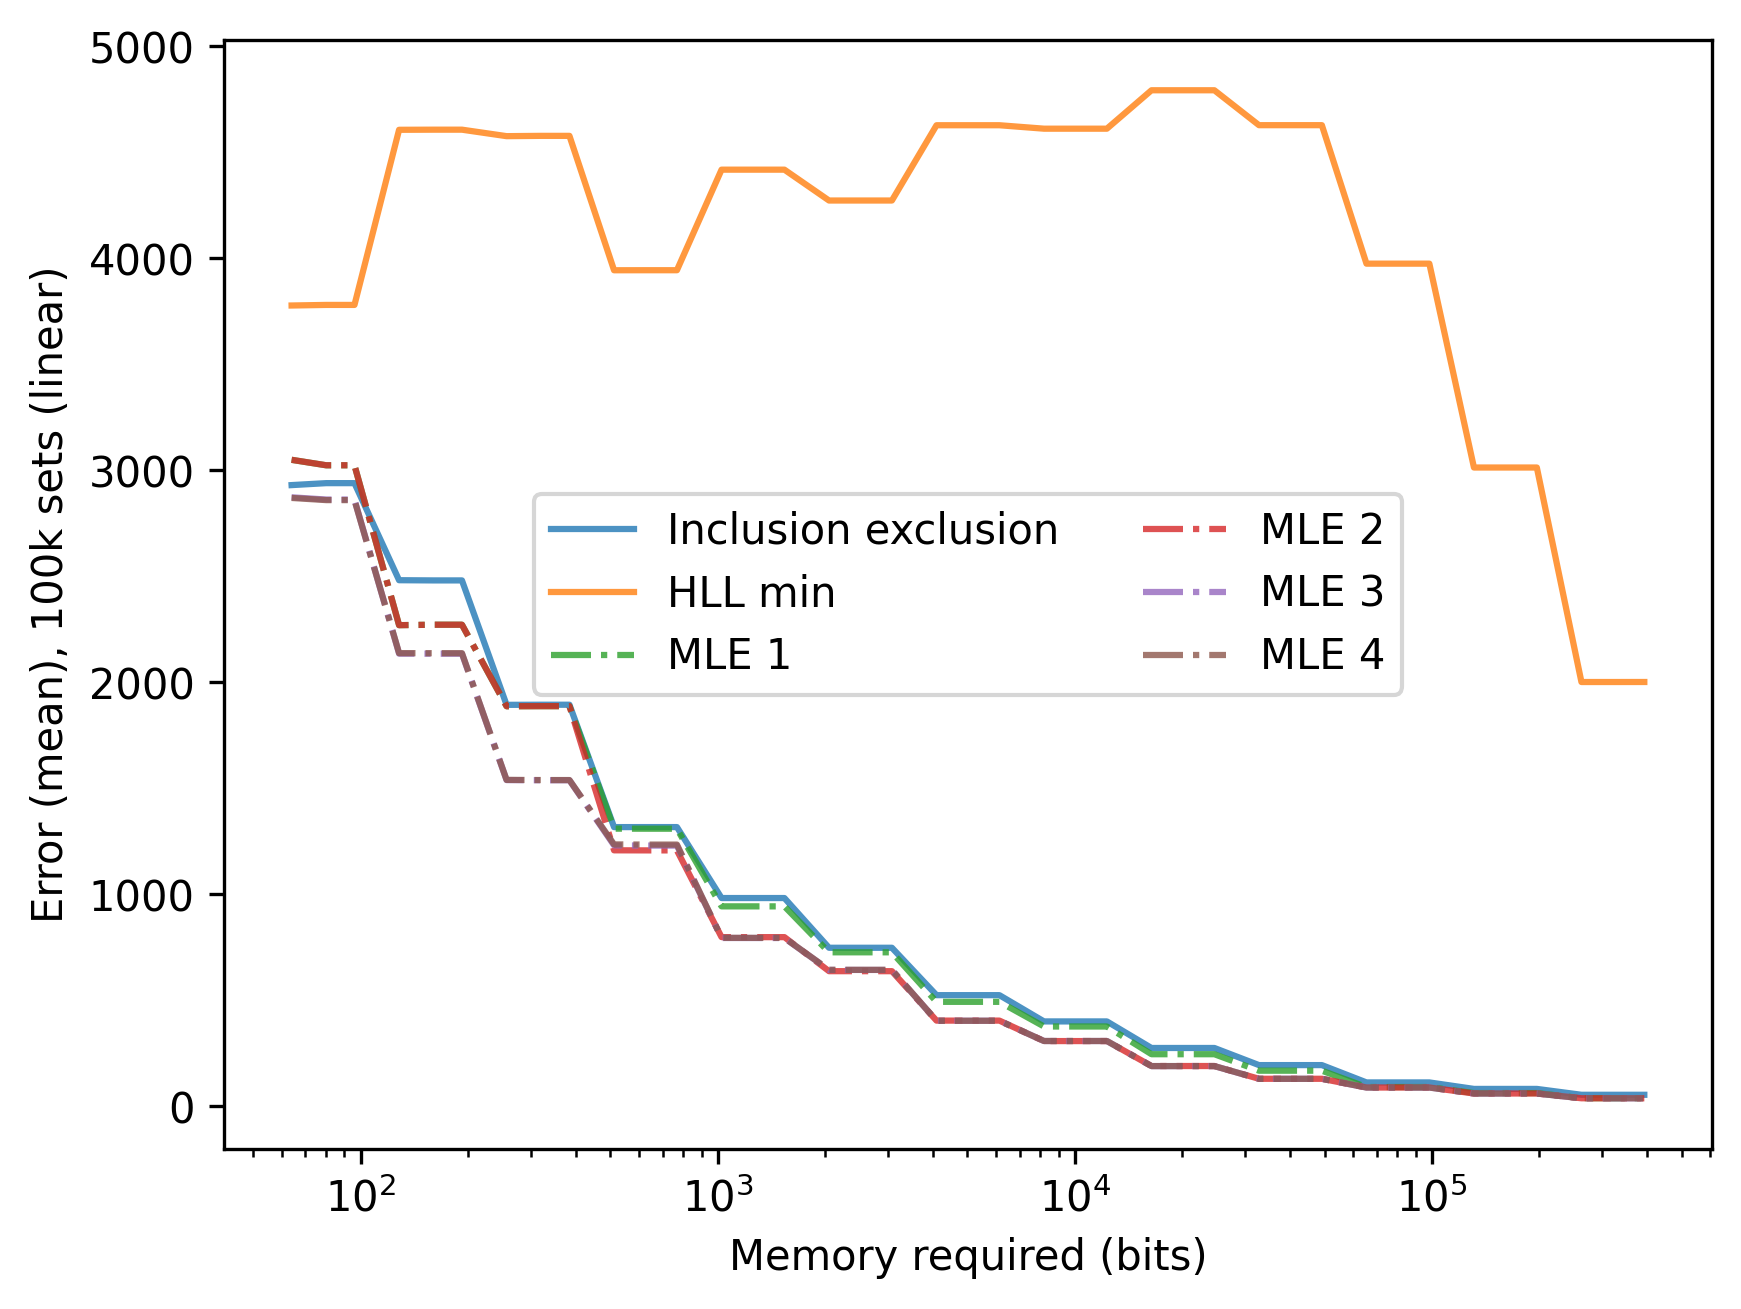

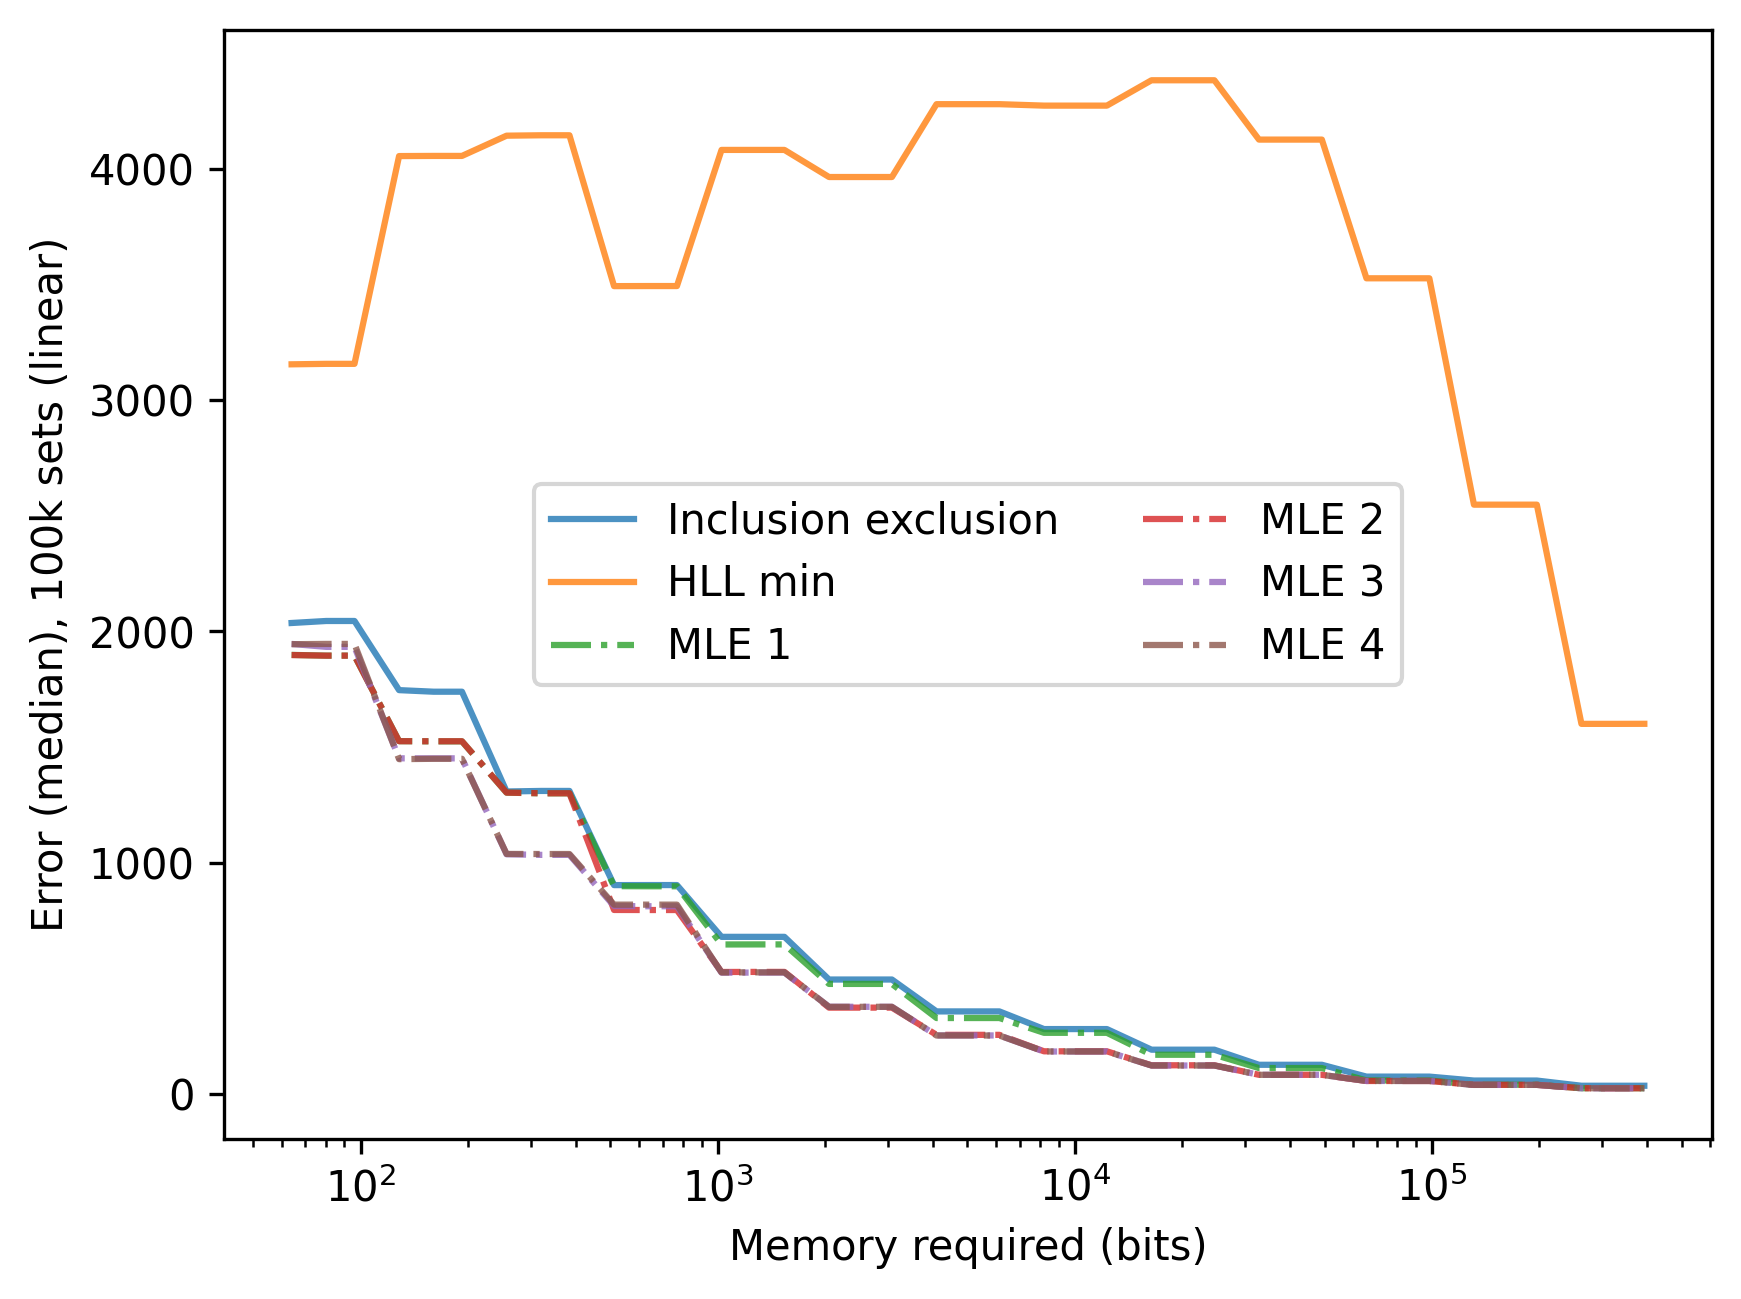

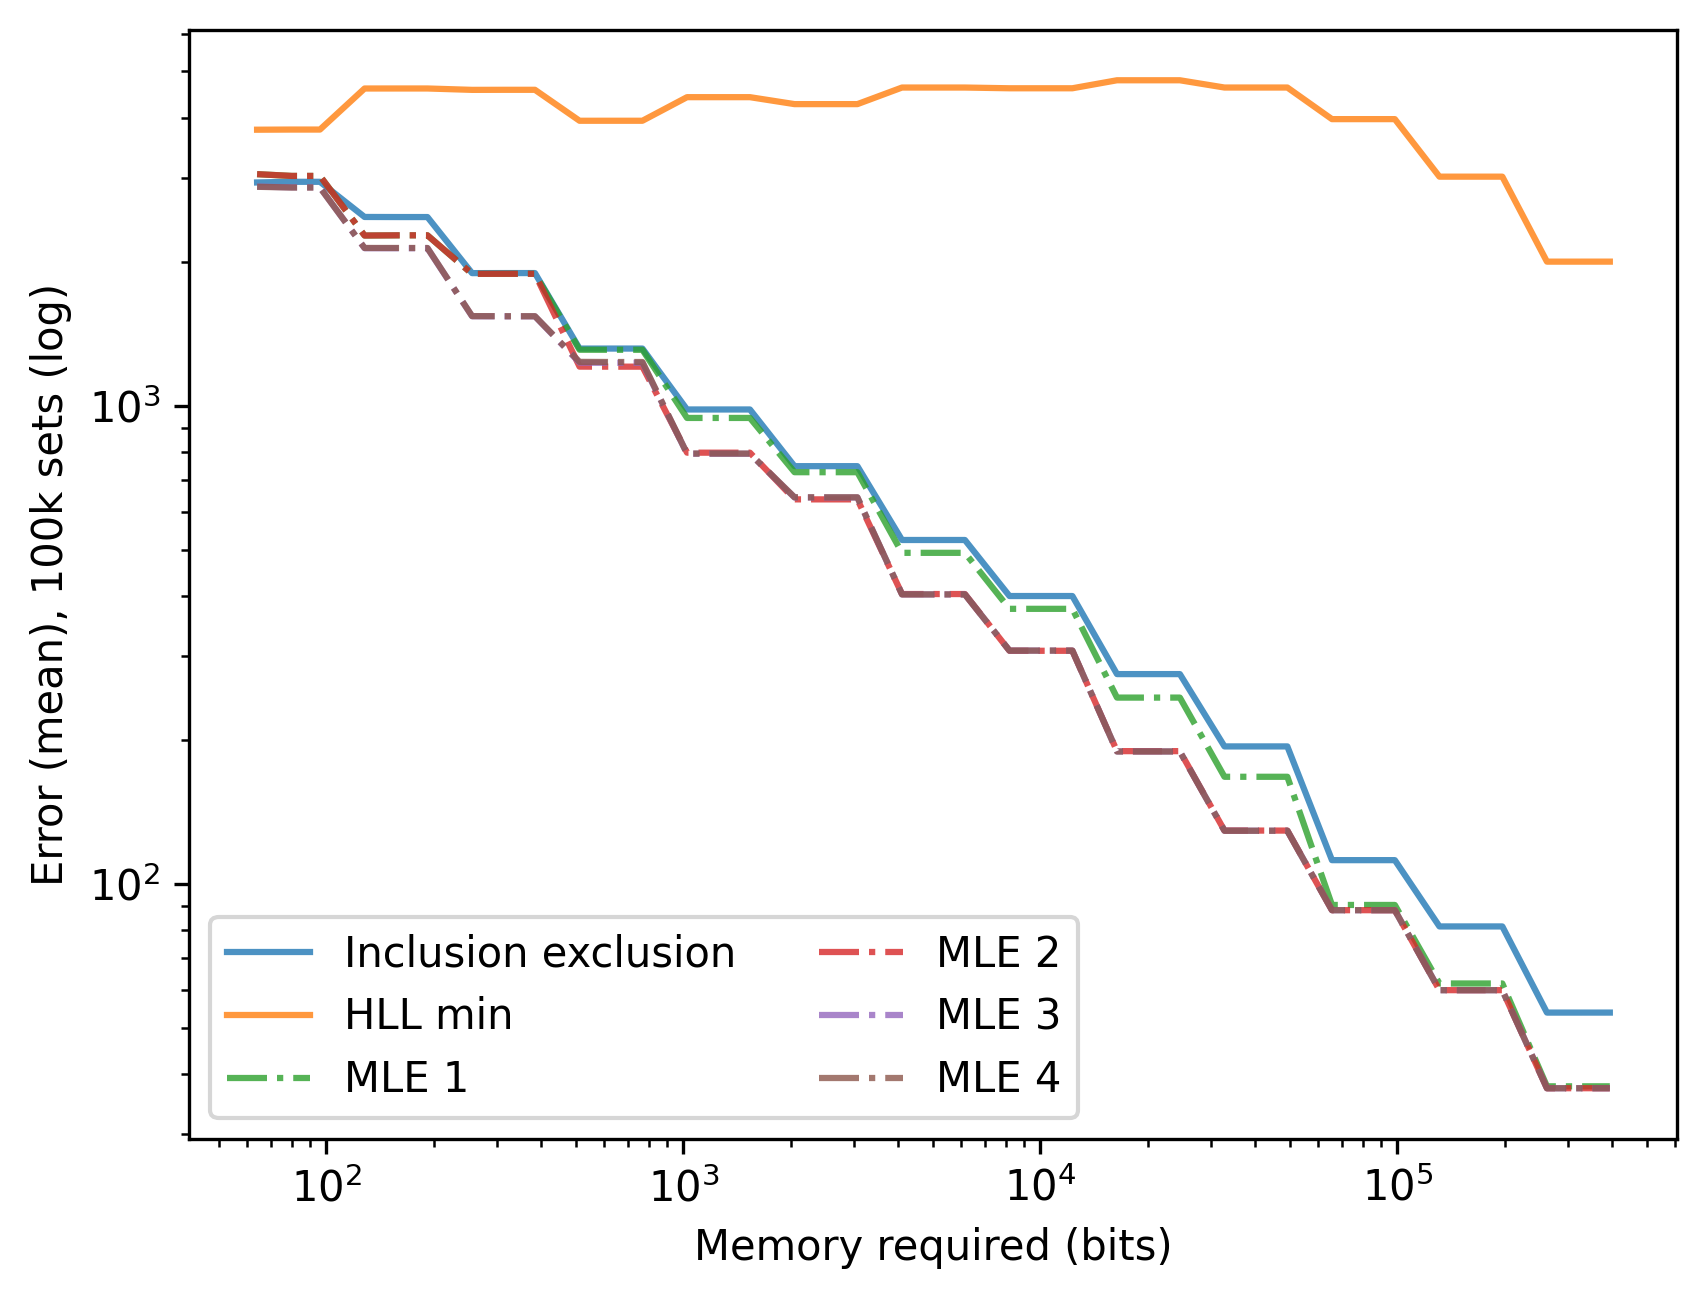

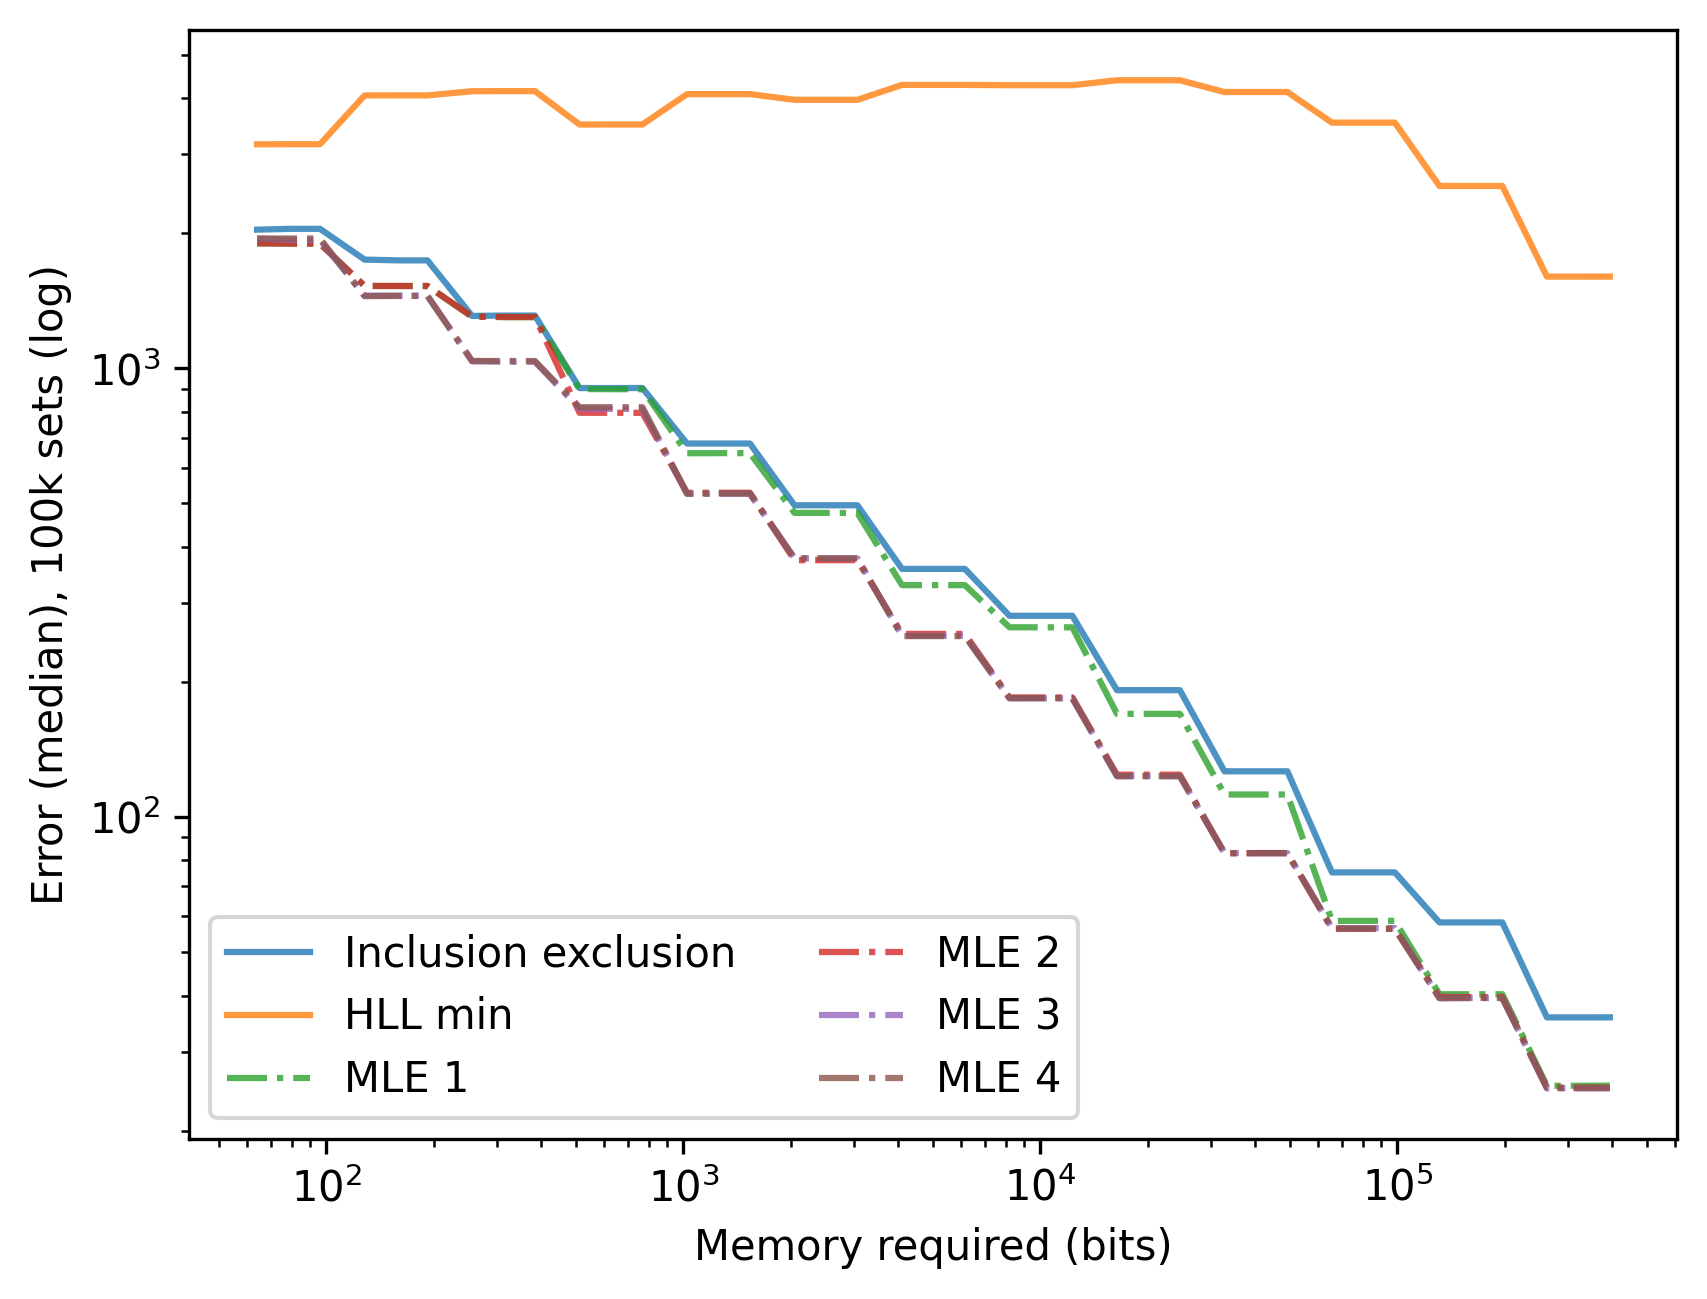

In [8]:
import matplotlib.pyplot as plt
from sanitize_ml_labels import sanitize_ml_labels

for yscale in ("linear", "log"):
    for metric in ("mean", "median"):
        fig, axes = plt.subplots(dpi=300)
        for (column, estimation) in zip(errors, estimations):
            plt.plot(
                data_hll.memory,
                data_hll[column][metric],
                #filtered[column]["std"],
                ls='-.' if "mle" in estimation else "-",
                alpha=0.8,
                label=f"{sanitize_ml_labels(estimation)}"
            )
        plt.legend(ncols=2)
        plt.xscale("log")
        plt.yscale(yscale)
        plt.ylabel(f"Error ({metric}), 100k sets ({yscale})")
        plt.xlabel("Memory required (bits)")
        plt.show()

## Error per time requirements

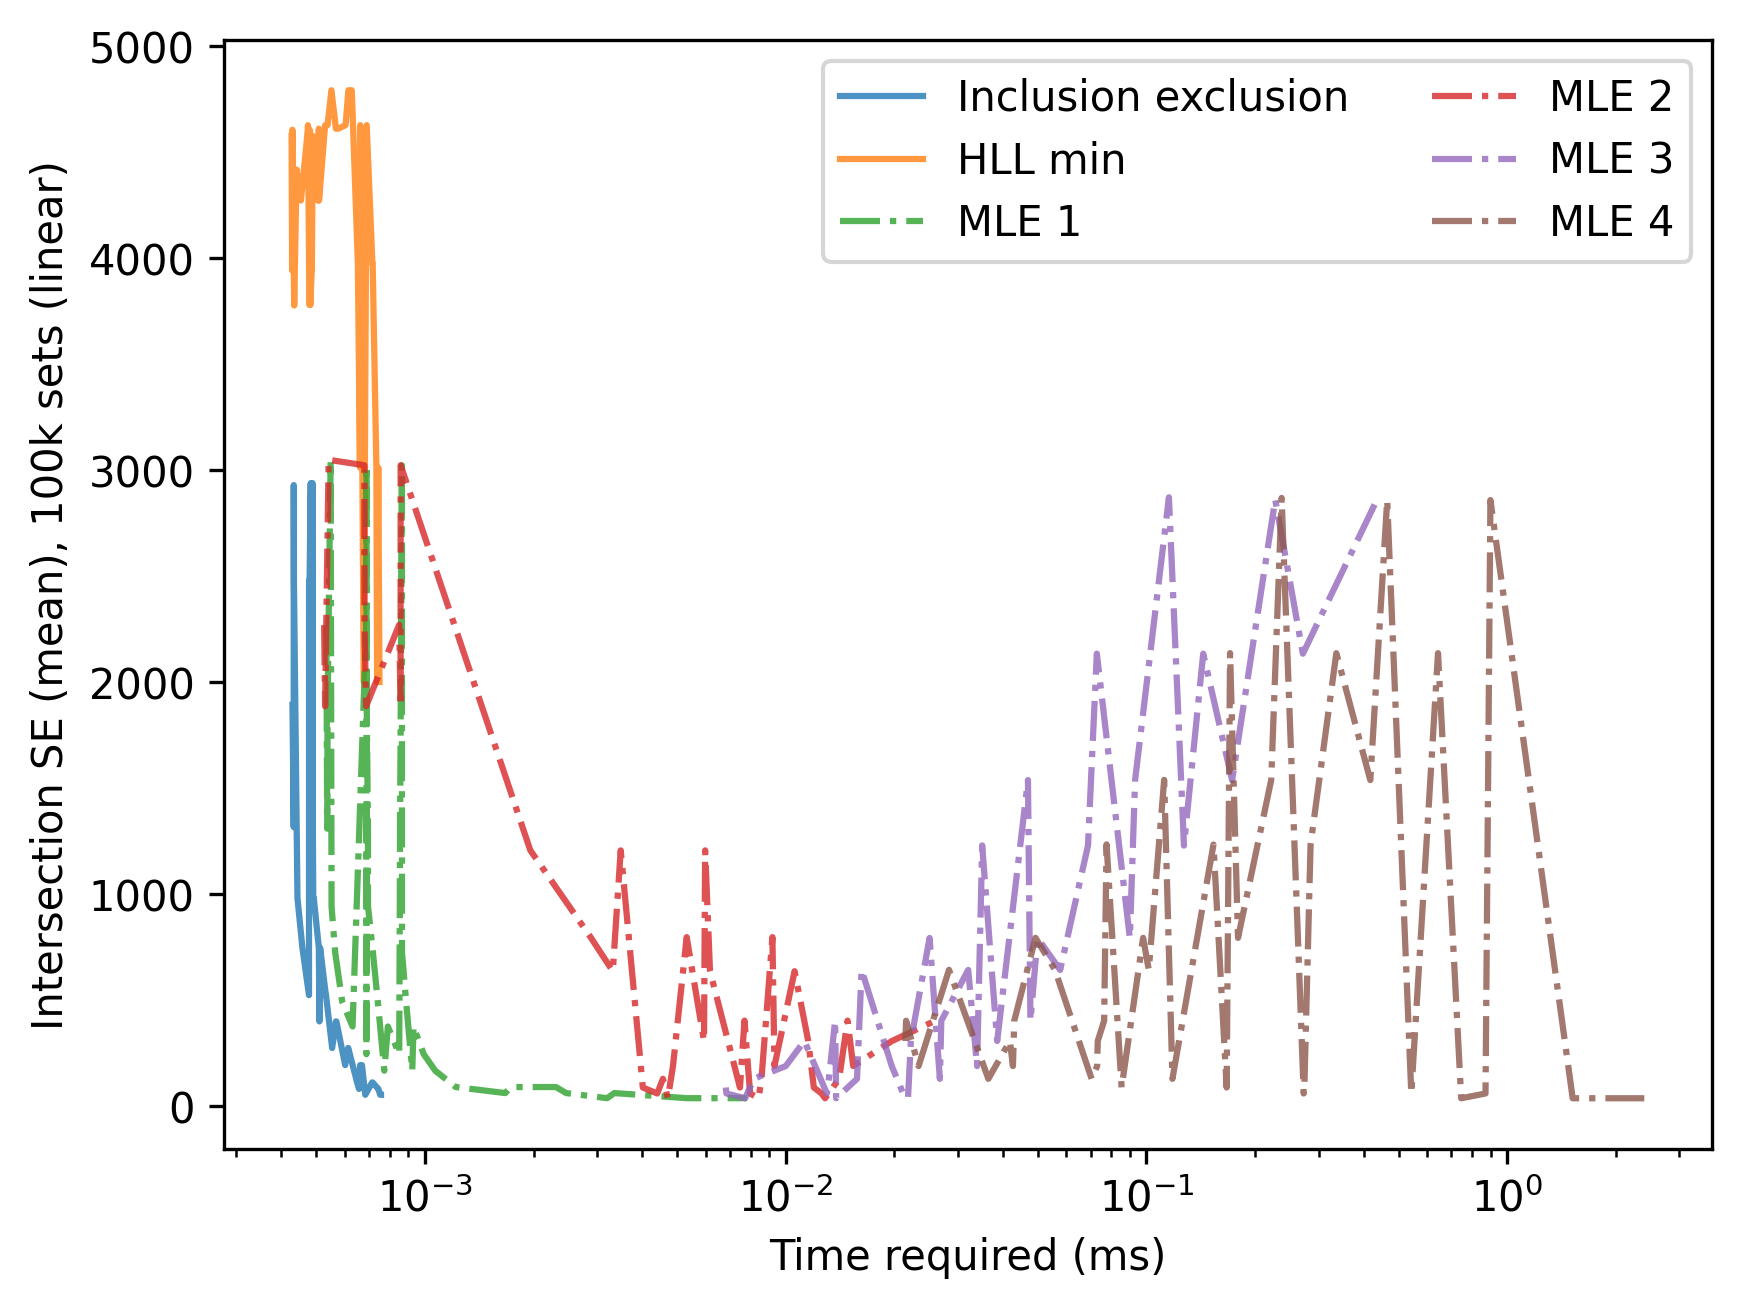

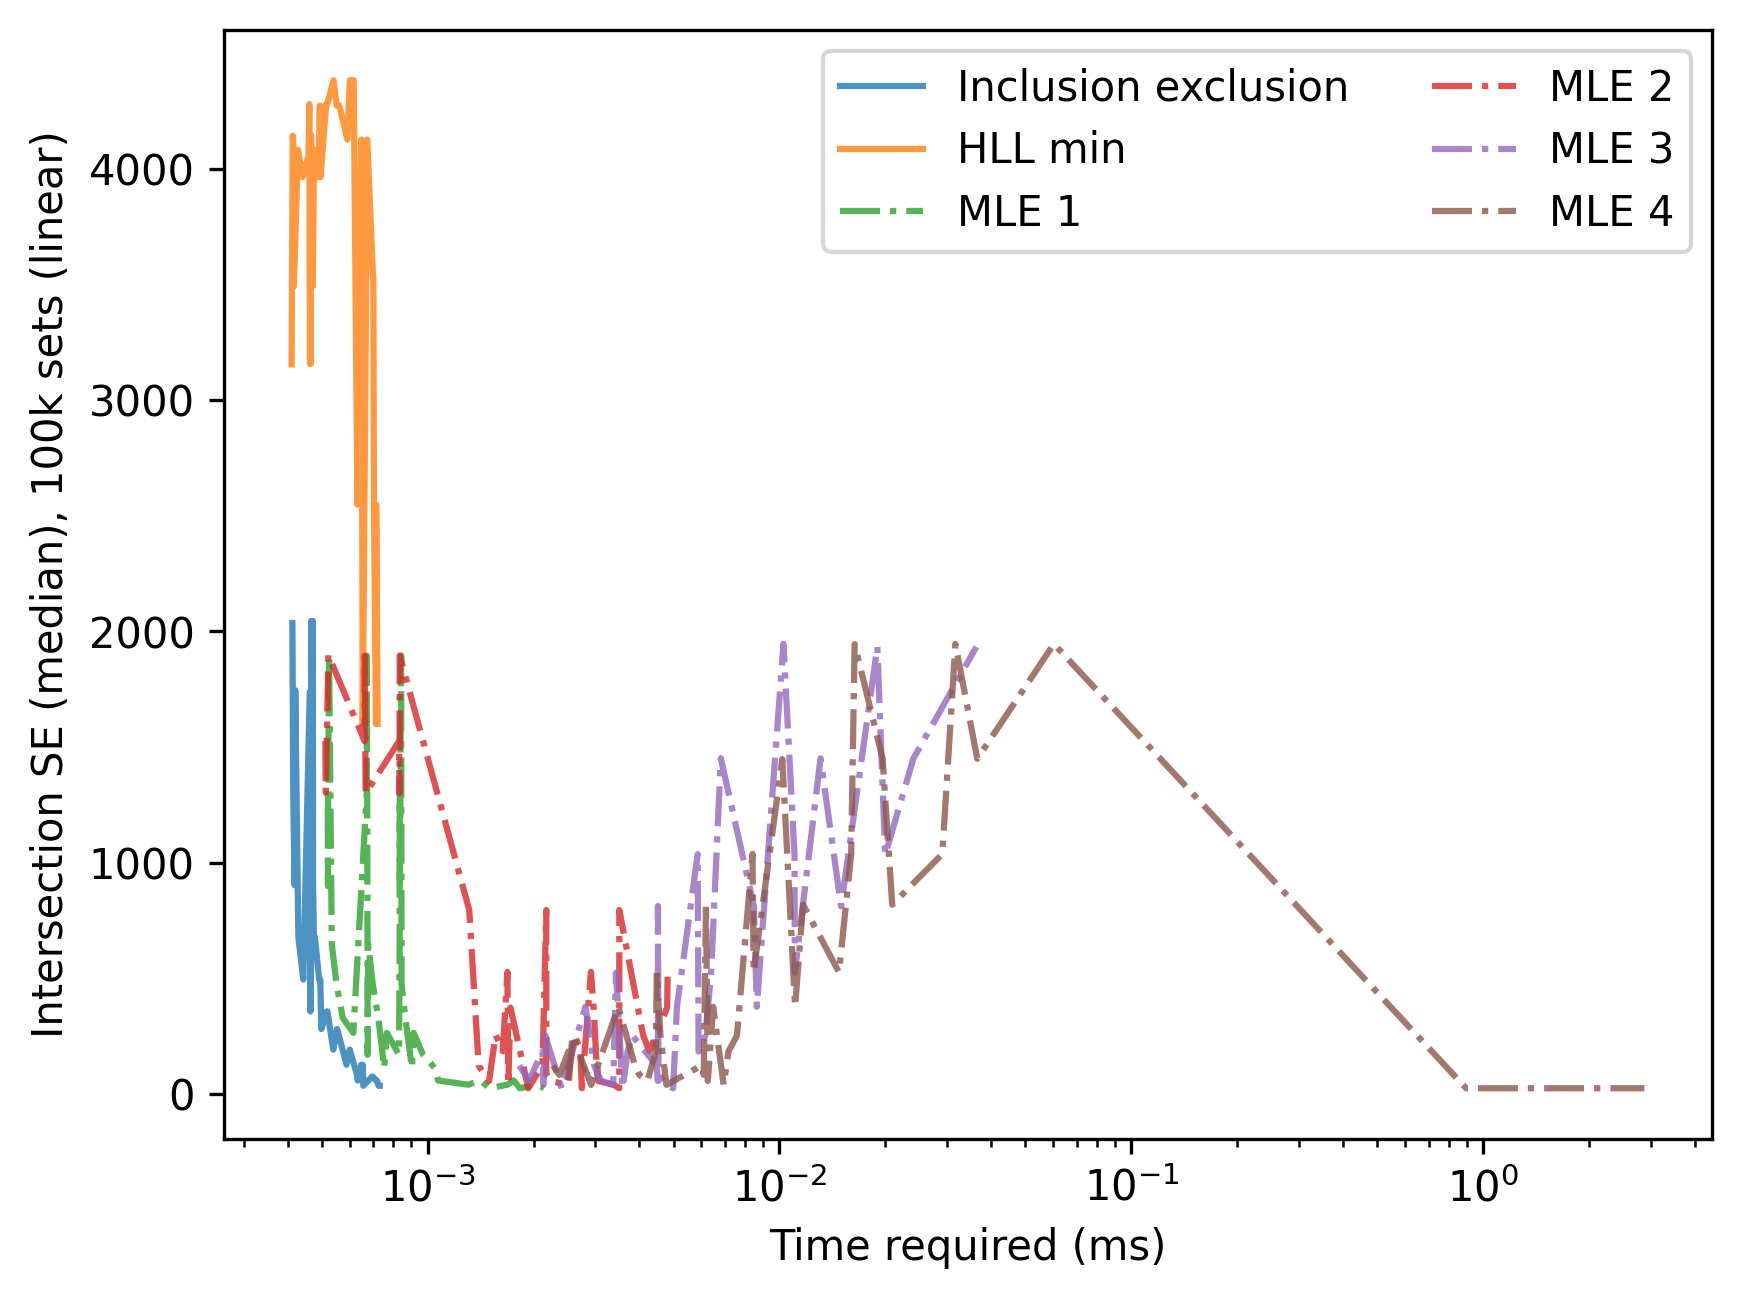

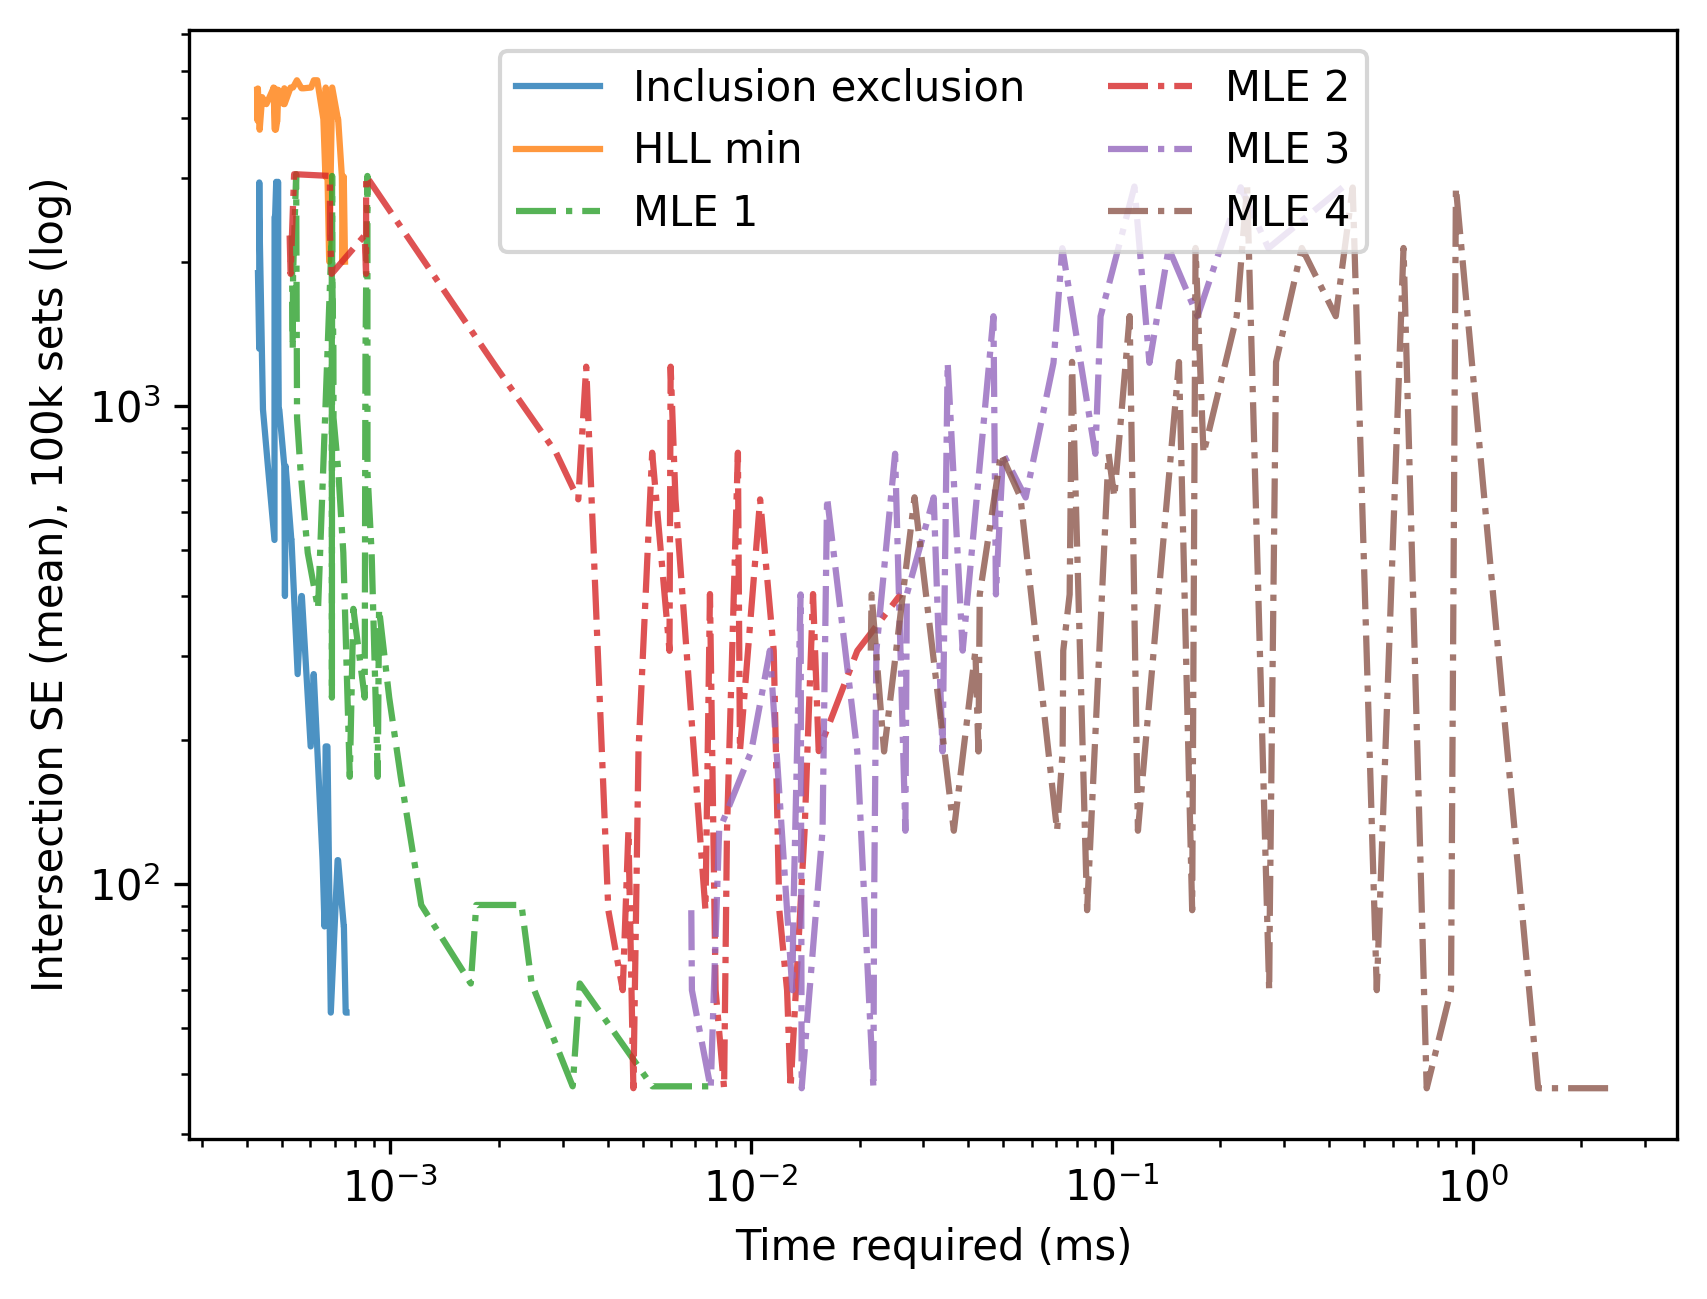

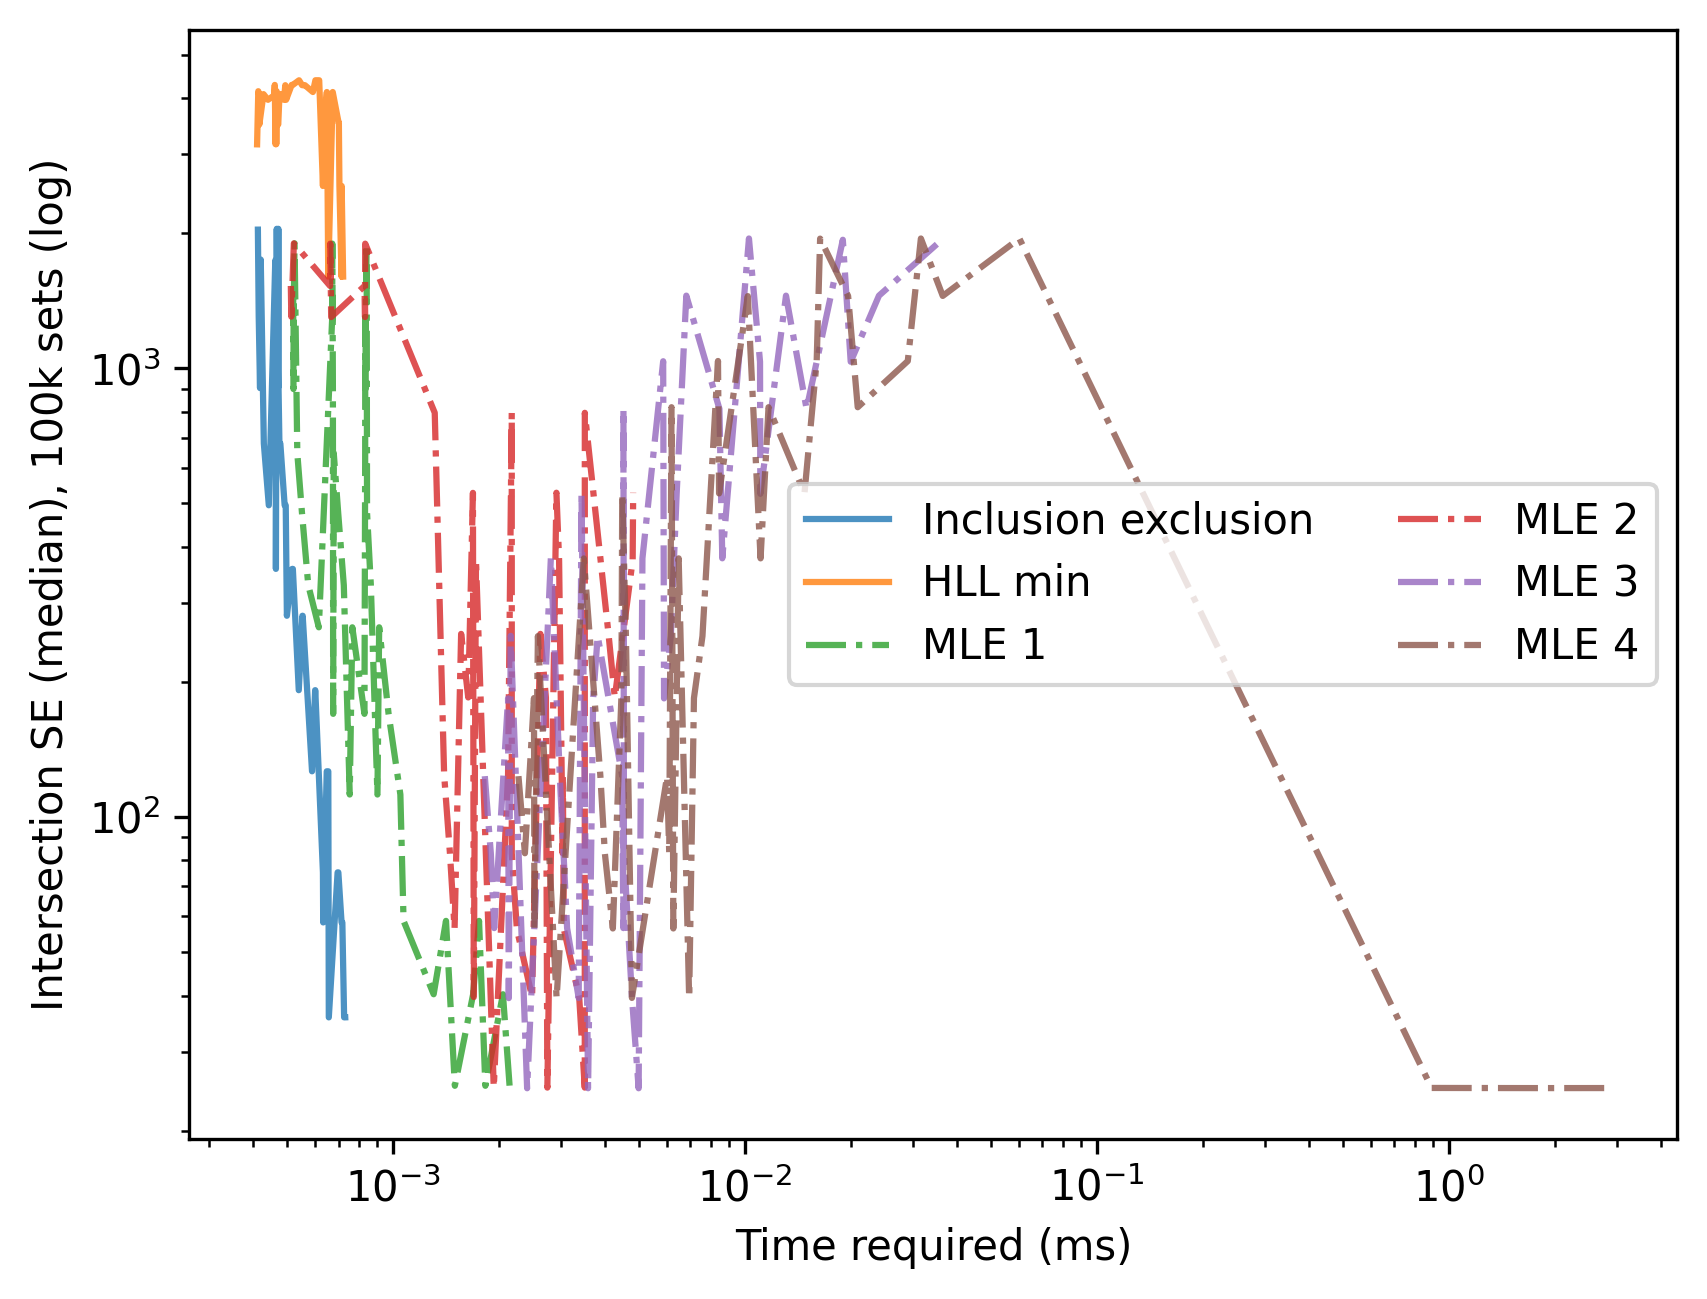

In [9]:
import matplotlib.pyplot as plt
from sanitize_ml_labels import sanitize_ml_labels

for yscale in ("linear", "log"):
    for metric in ("mean", "median"):
        fig, axes = plt.subplots(dpi=300)
        for (estimation, error_column) in zip(estimations, errors):
            time_column = f"time_{estimation}"
            sorted_data = data_hll.copy().sort_values((time_column, metric))

            time = sorted_data[time_column]

            plt.plot(
                time[metric],
                sorted_data[error_column][metric],
                alpha=0.8,
                ls='-.' if "mle" in estimation else "-",
                label=f"{sanitize_ml_labels(estimation)}"
            )
        plt.legend(ncols=2)
        plt.xscale("log")
        plt.yscale(yscale)
        plt.ylabel(f"Intersection SE ({metric}), 100k sets ({yscale})")
        plt.xlabel("Time required (ms)")
        plt.show()

## Combined

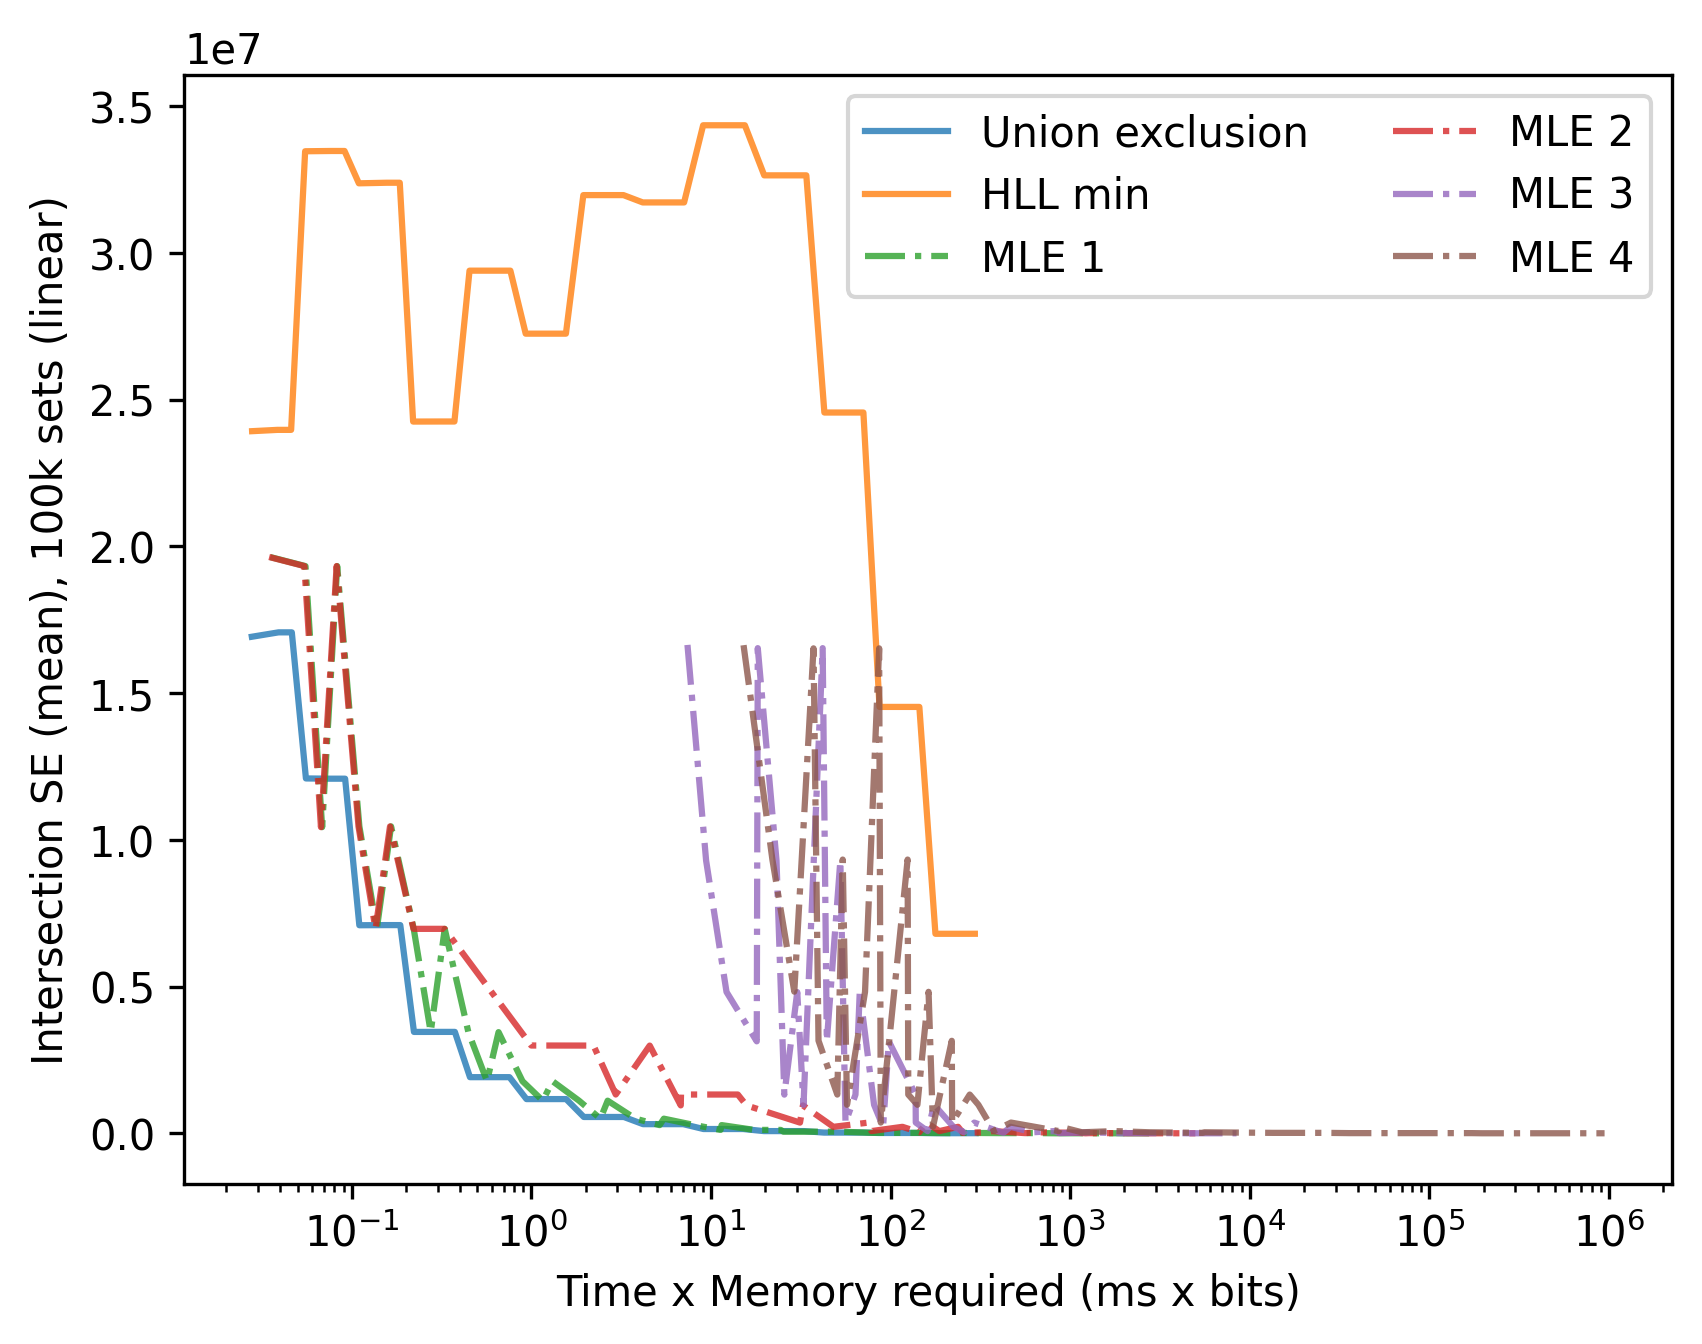

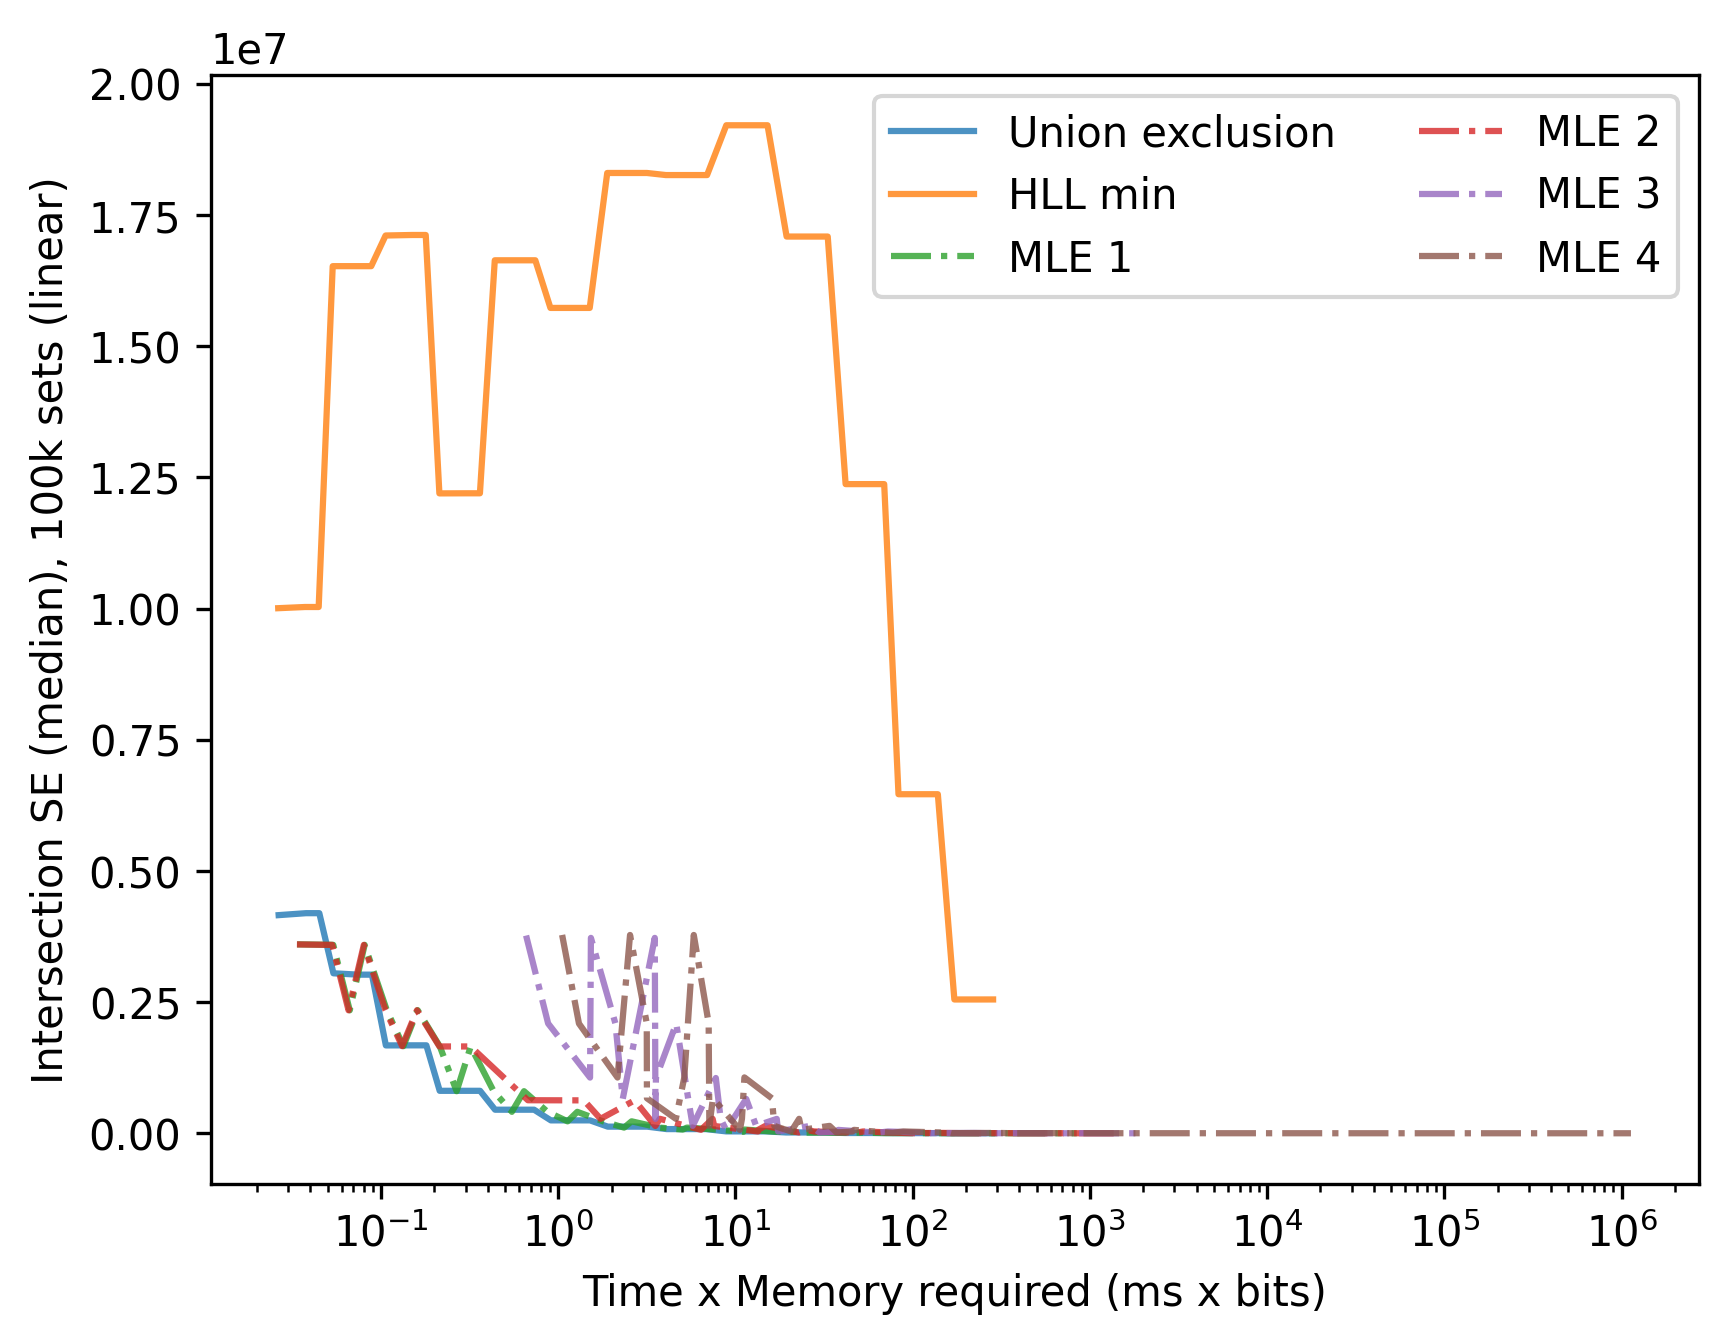

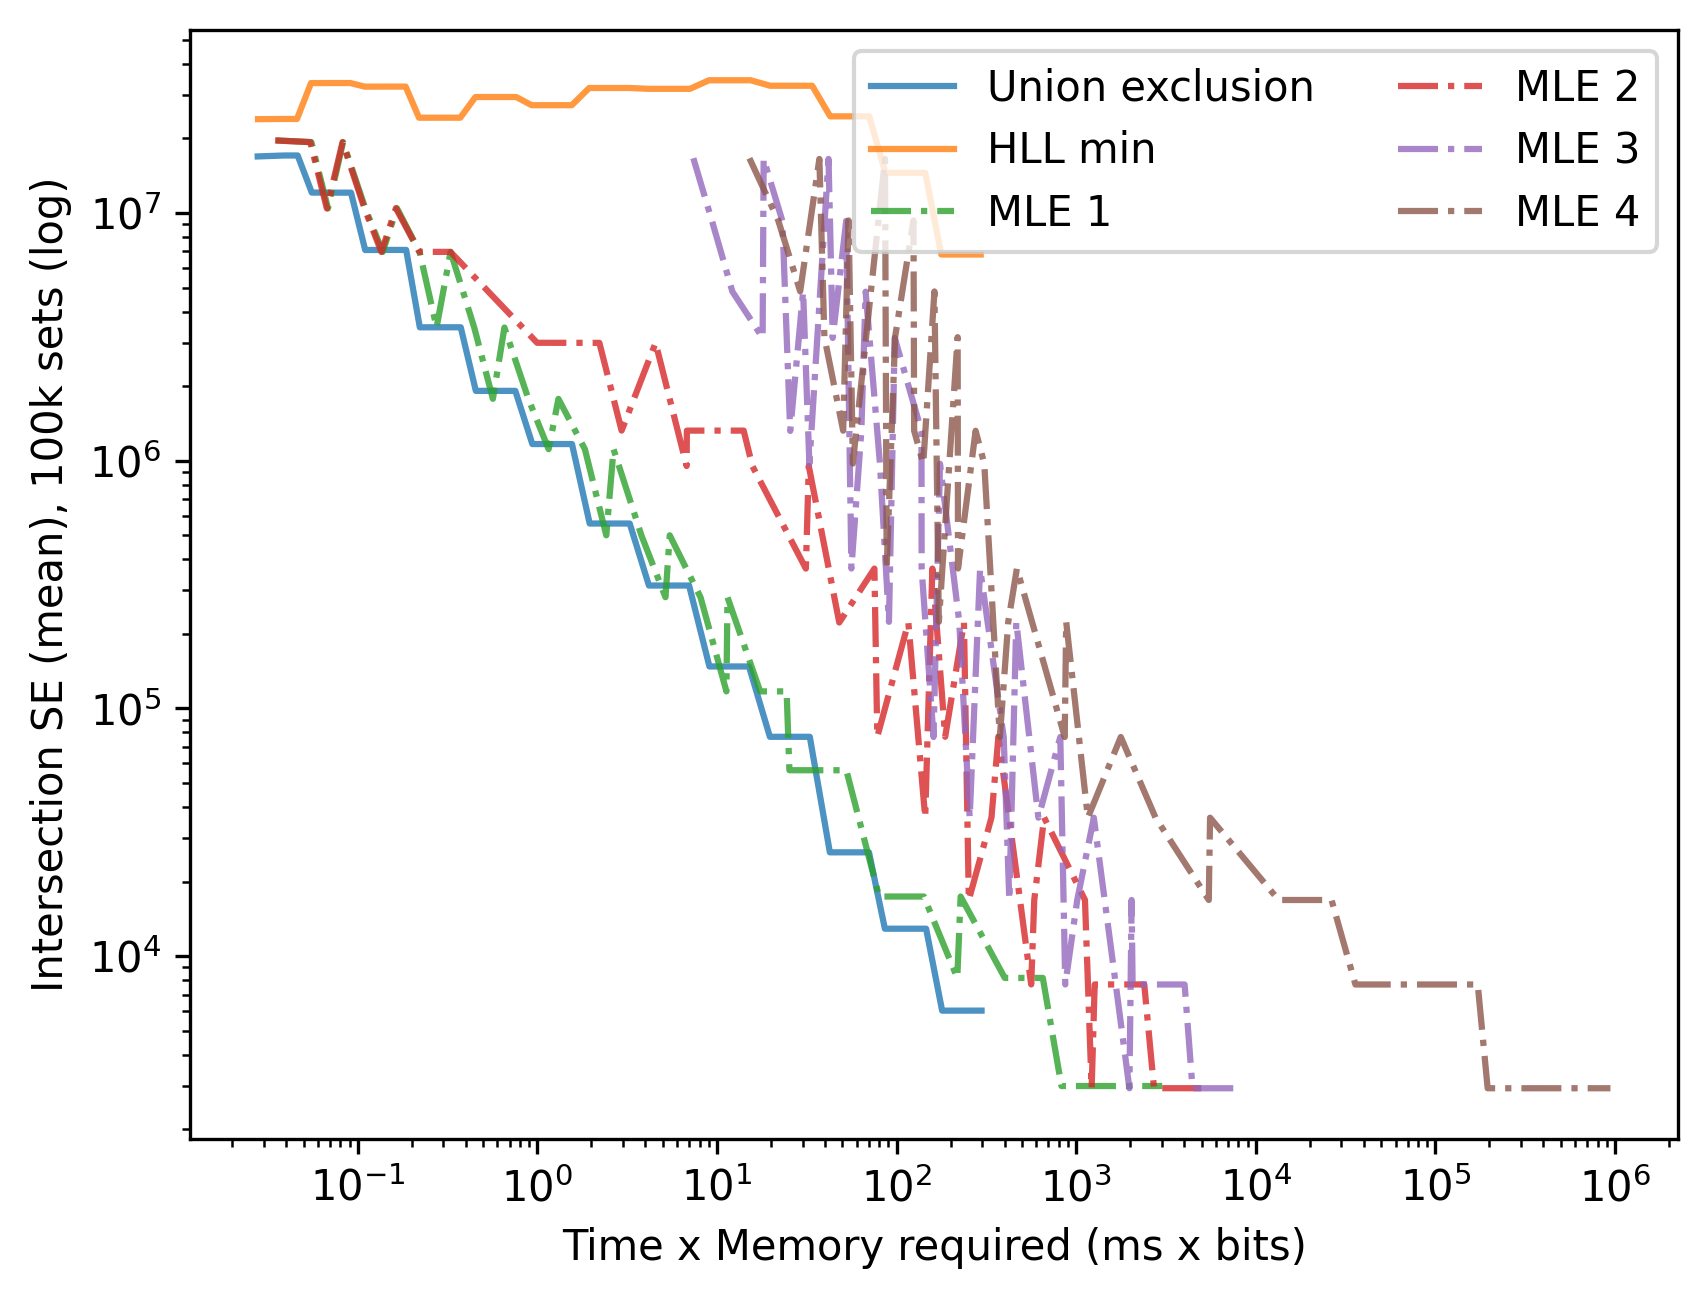

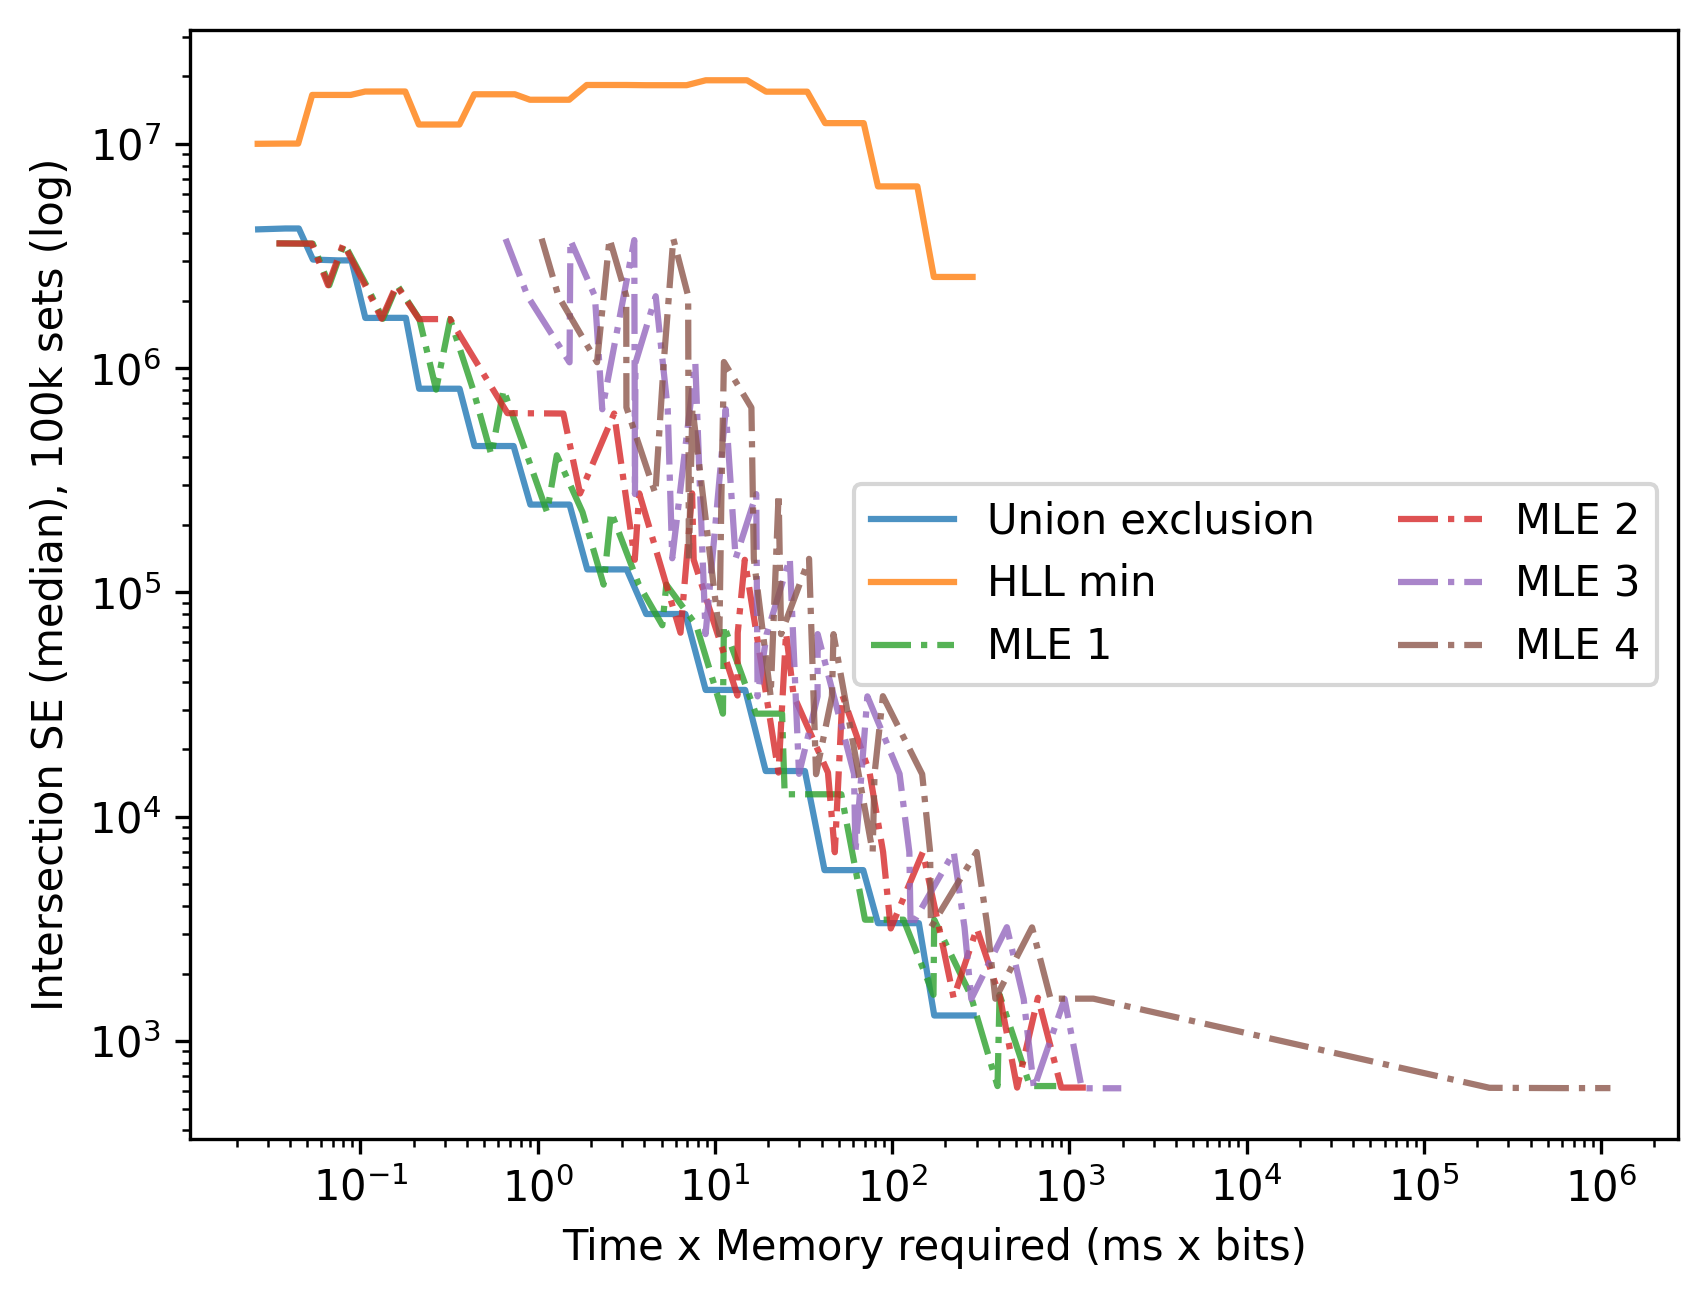

In [4]:
import matplotlib.pyplot as plt
from sanitize_ml_labels import sanitize_ml_labels

for yscale in ("linear", "log"):
    for metric in ("mean", "median"):
        fig, axes = plt.subplots(dpi=300)
        for (estimation, error_column) in zip(estimations, errors):
            time_column = f"time_{estimation}"

            data_hll["combined"] = data_hll[time_column][metric] * data_hll.memory
            data_hll = data_hll.sort_values("combined")

            plt.plot(
                data_hll["combined"],
                data_hll[error_column][metric],
                alpha=0.8,
                ls='-.' if "mle" in estimation else "-",
                label=f"{sanitize_ml_labels(estimation)}"
            )
        plt.legend(ncols=2)
        plt.xscale("log")
        plt.yscale(yscale)
        plt.ylabel(f"Intersection SE ({metric}), 100k sets ({yscale})")
        plt.xlabel("Time x Memory required (ms x bits)")
        plt.show()